# Alternating Projections Algorithms for Nonnegative Low Rank Tensor Approximation

## 0.

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

import matplotlib_inline

In [2]:
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [3]:
labels = ['норма Чебышёва', 'норма Фробениуса', 'Плотность']
colors = ['C0', 'C1', 'C2']
yticks = [10**(-x) for x in range(-1, 16, 2)]

In [473]:
def get_alg_name(func, distribution, **p):
    d = 'N' if distribution=='normal' else 'Rad'
    if 'rho' in p.keys():
        rho = p.pop('rho')
    else:
        rho = None
    if len(p) < 2:
        p = list(p.values())[0]
        alg_name = f'{func.__name__}({p}), {d}'
    else:
        if func.__name__ == 'HMT':
            p0 = p['p']
            p1 = p['k']
        elif func.__name__ == 'Tropp':
            p0 = p['k']
            p1 = p['l']
        alg_name = f'{func.__name__}({p0},{p1}), {d}'
    if d == 'N':
        alg_name += '(0,1)'
    elif rho is not None:
        alg_name += f'({rho})'
    return alg_name

In [474]:
class Info:
    def __init__(self, alg, params):
        self._alg = alg
        self._info = {'fro': [], 'chebyshev': [], 'density': []}
        self._params = params
    
    def clear(self):
        self._info = {'fro': [], 'chebyshev': [], 'density': []}

    def update(self, a):
        self._info['fro'].append(np.linalg.norm(a[a < 0]))
        neg_count = (a < 0).sum()
        self._info['density'].append(neg_count/(np.prod(a.shape)))
        if len(a[a < 0]) > 0:
            self._info['chebyshev'].append(max(abs(a[a < 0])))
        else:
            self._info['chebyshev'].append(0)
        
    def get_info(self):
        return self._info
    
    def get_name(self):
        if self._alg.__name__ in ['SVD', 'Tangent']:
            return self._alg.__name__
        return get_alg_name(self._alg, **self._params)

## 1. Algorithms

### 1.0

In [475]:
def svdr(a, r):
    u, s, vh = sp.linalg.svd(a, full_matrices=False)
    return u[:, :r], s[:r], vh[:r, :]

In [476]:
def TestMatrix(m, n, distribution='normal', p=None):
    if distribution == 'normal':
        res = np.random.normal(size=(m, n))
    elif distribution == 'rademacher' and p is None:
        res = np.random.choice([-1,1], size=(m,n))
    elif distribution == 'rademacher':
        res = np.random.choice([0,1,-1], size=(m,n), p=[1-p,p/2,p/2])
    else:
        raise TypeError('Invalid arguments')
    return res

### 1.1 SVD

In [477]:
def SVD(X, r):
    Ur, Sr, Vhr = svdr(X, r)
    
    return Ur, Sr, Vhr

### 1.2 Tangent

In [478]:
# def Tangent(X, r):
#     return Ur, Sr, Vhr

### 1.3 HMT

In [479]:
def HMT(X, r, p, k, distribution='normal', rho=None):
    m, n = X.shape

    Psi = TestMatrix(n, k, distribution, rho)
    Z1 = X @ Psi
    Q, R = np.linalg.qr(Z1)
    for j in range(p):
        Z2 = Q.T @ X
        Q, R = np.linalg.qr(Z2.T)
        Z1 = X @ Q
        Q, R = np.linalg.qr(Z1)
    Z2 = Q.T @ X
    Ur, Sr, Vhr = svdr(Z2, r)
    Ur = Q @ Ur
    
    return Ur, Sr, Vhr

### 1.4 Tropp

In [480]:
def Tropp(X, r, k, l, distribution='normal', rho=None):
    m, n = X.shape
        
    Psi = TestMatrix(n, k, distribution, rho)
    Phi = TestMatrix(l, m, distribution, rho)
    Z = X @ Psi
    Q, R = np.linalg.qr(Z)
    W = Phi @ Q
    P, T = np.linalg.qr(W)
    G = np.linalg.inv(T) @ P.T @ Phi @ X
    Ur, Sr, Vhr = svdr(G, r)
    Ur = Q @ Ur
    
    return Ur, Sr, Vhr

### 1.5 GN (generalized Nystrom method)

In [481]:
def GN(X, r, l, distribution='normal', rho=None):
    m, n = X.shape

    Psi = TestMatrix(n, r, distribution, rho)
    Phi = TestMatrix(l, m, distribution, rho)
    Z = X @ Psi
    W = Phi @ Z
    Q, R = np.linalg.qr(W)
    V = (Phi@X).T @ Q
    U = Z @ np.linalg.inv(R)
        
    return U, V.T

## 2. My HOSVD

In [560]:
def unfold(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1))

def fold(unfolded_tensor, mode, shape):
    full_shape = list(shape)
    mode_dim = full_shape.pop(mode)
    full_shape.insert(0, mode_dim)
    return np.moveaxis(np.reshape(unfolded_tensor, full_shape), 0, mode)

def mode_product(tensor, matrix, mode):
    if tensor.shape[mode] != matrix.shape[0]:
        raise RuntimeError(f'tensor.shape[{mode}] != matrix.shape[0]')
    new_shape = list(tensor.shape)
    new_shape[mode] = matrix.shape[1]
    tensor_mode = unfold(tensor, mode)
    return fold(matrix.T @ tensor_mode, mode, new_shape)

def restore_tensor(s, u_list):
    res = mode_product(s, u_list[0].T, 0)
    for k, u in enumerate(u_list[1:], 1):
        res = mode_product(res, u.T, k)
    return res

In [561]:
def HOSVD(a, r):
    S = a.copy()
    U_list = []
    for k, nk in enumerate(a.shape):
        ak = unfold(a, k)
        u, _, _  = svdr(ak, r[k])
        U_list.append(u)
        S = mode_product(S, u, k)
    return S, U_list

def myHOSVD(a, r, alg, alg_params=None, iters_num=100, info=None): # alternating projections
    if info:
        info.clear()
    for i in range(iters_num):
        S = a.copy()
        U_list = []
        S[S < 0] = 0
        for k, nk in enumerate(a.shape):
            ak = unfold(S, k)
            if alg_params is None:
                u, *g  = alg(ak, r[k])
            else:
                u, *g  = alg(ak, r[k], **alg_params)
            if len(g) > 1:
                s  = g[0]
                vh = g[1]
                vh = (s * vh.T).T
            else:
                vh = g[0]
            shape = list(S.shape)
            shape[k] = r[k]
            S = fold(vh, k, shape)
            U_list.append(u)
        a = restore_tensor(S, U_list)
        if info:
            info.update(a)
    return S, U_list

def myHOSVD2(a, r, alg, alg_params=None, iters_num=100, info=None): # alternating projections, медленно
    if info:
        info.clear()
    for i in range(iters_num):
        S = a.copy()
        U_list = []
        S[S < 0] = 0
        for k, nk in enumerate(a.shape):
            ak = unfold(a, k)
            if alg_params is None:
                u, *_  = alg(ak, r[k])
            else:
                u, *_  = alg(ak, r[k], **alg_params)
            U_list.append(u)
            S = mode_product(S, u, k)
        a = restore_tensor0(S, U_list)
        if info:
            info.update(a)
    return S, U_list

## 3. Numerical experiments

### 3.1 Color image 512x512

In [790]:
img = mpimg.imread('img3D.jpg')
r = [60, 60, 3]
img.shape

(512, 512, 3)

In [791]:
# SVD_r

start = time.time()
s, u_list = HOSVD(img, r)
end = time.time()
print(end-start, 's.')


img_ = restore_tensor(s, u_list)
img_ = img_.astype(int)

res = img_
print('Frobenius       |', np.linalg.norm(res[res < 0]))
if len(res[res < 0]) > 0:
    print('Chebyshev       |', max(abs(res[res < 0])))
else:
    print('Chebyshev       | 0.0')
neg_count = (res < 0).sum()
print('Density         |', neg_count/(np.prod(res.shape)))
print('rel. error(fro) |', np.linalg.norm(img - res) / np.linalg.norm(img))
print('rel. error(che) |', np.max(abs(img - res)/ np.max(abs(img))))

0.5081982612609863 s.
Frobenius       | 207.34994574390416
Chebyshev       | 25
Density         | 0.0013147989908854167
rel. error(fro) | 0.038090581088307054
rel. error(che) | 0.30196078431372547


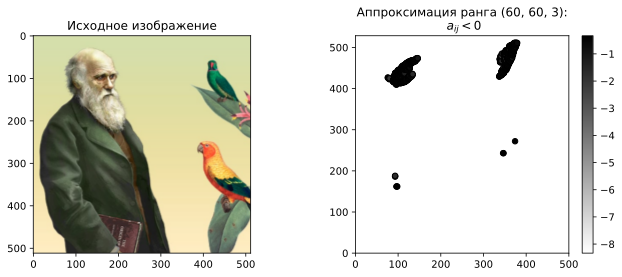

In [792]:
neg = img_.copy()
neg[neg >= 0] = 0
neg = neg.mean(axis=2)


fig, ax = plt.subplots(1, 2, figsize=(11, 4))

ax[0].imshow(img)
ax[0].set_title('Исходное изображение')

plt.set_cmap('gray_r')
ax[1].set_title('Аппроксимация ранга (%d, %d, %d):\n $a_{ij} < 0$' % (r[0], r[1], r[2], ))
sc = ax[1].scatter(*np.where(neg < 0), s=30, c=neg[np.where(neg < 0)], edgecolors='black')
_ = plt.colorbar(sc)

for i in range(2):
    ax[i].set_xticks(range(0, 513, 100))
    ax[i].set_yticks(range(0, 513, 100))

plt.subplots_adjust(wspace=0.3)

In [793]:
iters_num = 600

algs = [SVD, HMT, HMT, Tropp, GN, GN]
params = [None,\
          dict(p=1, k=70, distribution='normal'),
          dict(p=0, k=70, distribution='rademacher',   rho=0.2),\
          dict(k=70, l=100, distribution='rademacher', rho=0.2),\
          dict(l=150, distribution='rademacher', rho=0.2),\
          dict(l=120, distribution='rademacher', rho=0.2)]

# info_list = [info_svd, info_tangent,\
#              info_hmt1, info_hmt2,\
#              info_tropp1, info_tropp2,\
#              info_gn1, info_gn2]

# img_list = [img_svd, img_tangent,\
#              img_hmt1, img_hmt2,\
#              img_tropp1, img_tropp2,\
#              img_gn1, img_gn2]
info_list = []
img_list  = []
for i in range(len(algs)):
    info = Info(algs[i], params[i])
    
    print(info.get_name() + '...')
    start = time.time()
    s, u_list = myHOSVD(img, r, algs[i], alg_params=params[i], iters_num=iters_num, info=info)
    end = time.time()
    print(end-start)
    
    img_list.append(restore_tensor(s, u_list))
    info_list.append(info)


for i in range(len(info_list)):
    info = info_list[i]
    res  = img_list[i]
    
    print('-'*50)
    print(info.get_name())
    print('-'*50)

    print('Frobenius  |', np.linalg.norm(res[res < 0]))
    if len(res[res < 0]) > 0:
        print('Chebyshev  |', max(abs(res[res < 0])))
    else:
        print('Chebyshev  | 0.0')
    neg_count = (res < 0).sum()
    print('Density    |', neg_count/(np.prod(res.shape)))
    print('rel. error(fro) |', np.linalg.norm(img - res) / np.linalg.norm(img))
    print('rel. error(che) |', np.max(abs(img - res)/ np.max(abs(img))))
print('-'*50)

for i in range(len(img_list)):
    img_list[i] = img_list[i].astype(int)

SVD...
132.1721224784851
HMT(1,70), N(0,1)...
66.05976700782776
HMT(0,70), Rad(0.2)...
53.594401121139526
Tropp(70,100), Rad(0.2)...
53.55447053909302
GN(150), Rad(0.2)...
34.06202244758606
GN(120), Rad(0.2)...
34.29790997505188
--------------------------------------------------
SVD
--------------------------------------------------
Frobenius  | 0.003096341
Chebyshev  | 0.0010735624
Density    | 3.0517578125e-05
rel. error(fro) | 0.03755376373870863
rel. error(che) | 0.2941077
--------------------------------------------------
HMT(1,70), N(0,1)
--------------------------------------------------
Frobenius  | 1.6569911843158798e-12
Chebyshev  | 1.175460872363233e-12
Density    | 2.5431315104166665e-06
rel. error(fro) | 0.03872672952694993
rel. error(che) | 0.29399193198137086
--------------------------------------------------
HMT(0,70), Rad(0.2)
--------------------------------------------------
Frobenius  | 4.344176410843731e-12
Chebyshev  | 2.735791873514293e-12
Density    | 1.14440917

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


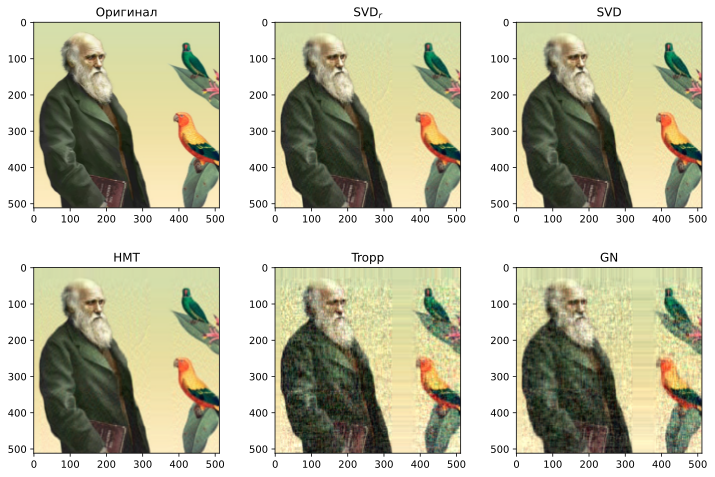

In [794]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

imgs = [img, img_, img_list[0], img_list[1], img_list[3], img_list[5]]
titles = ['Оригинал', r'SVD$_r$', 'SVD', 'HMT', 'Tropp', 'GN']

for i in range(2):
    for j in range(3):
#         set_title('$\\bf{%s}$\nРанг: %d, %d, %d' % (info_hmt.get_name(), r[0],r[1],r[2]))
        ax[i,j].set_title(titles[i*3+j])
        ax[i,j].set_xticks(range(0, 513, 100))
        ax[i,j].imshow(imgs[i*3+j])
        
plt.subplots_adjust(wspace=0.3, hspace=0.3)
#         ax[1].set_title('$\\bf{%s}$\nРанг: %d, %d, %d' % (info_hmt.get_name(), r[0],r[1],r[2]))

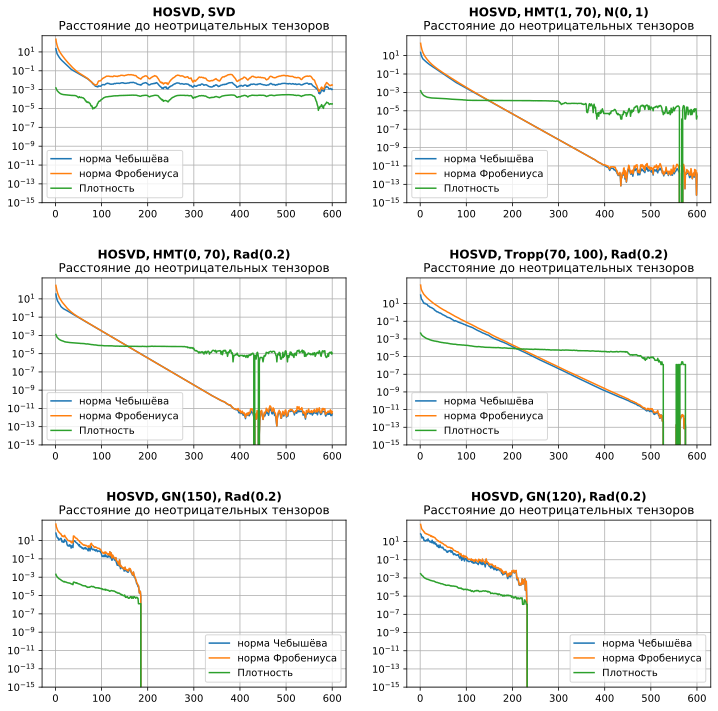

In [795]:
title = 'Расстояние до неотрицательных тензоров'
# alg_name = get_alg_name(HMT,'rademacher',0.2,0,80)
inf  = info_hmt.get_info()
s = iters_num
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

for i in range(3):
    for j in range(2):
        info = info_list[i*2 + j]
        norms = info.get_info()
        ax[i,j].plot(range(1, s+1), norms['chebyshev'], colors[0], label=labels[0])
        ax[i,j].plot(range(1, s+1), norms['fro'],       colors[1], label=labels[1])
        ax[i,j].plot(range(1, s+1), norms['density'],   colors[2], label=labels[2])

        ax[i,j].set_title('$\\bf{HOSVD, %s}$\n%s' % (info.get_name(), title))
        ax[i,j].grid()
        ax[i,j].set_yscale('log')
        ax[i,j].set_yticks(yticks)
        if i == 2:
            ax[i,j].legend(loc='lower right')
        else:
            ax[i,j].legend(loc='lower left')

plt.subplots_adjust(wspace=0.2, hspace=0.45)

plt.show()

### 3.2 Random 3D tensor

In [783]:
n = 128
a = np.random.rand(n,n,n)
r = [50, 50, 50]

In [784]:
iters_num = 700

algs = [SVD, HMT, HMT, Tropp, GN, GN]
params = [None,\
          dict(p=1, k=70, distribution='normal'),
          dict(p=0, k=70, distribution='rademacher',   rho=0.2),\
          dict(k=70, l=100, distribution='rademacher', rho=0.2),\
          dict(l=150, distribution='rademacher', rho=0.2),\
          dict(l=120, distribution='rademacher', rho=0.2)]

# info_list = [info_svd, info_tangent,\
#              info_hmt1, info_hmt2,\
#              info_tropp1, info_tropp2,\
#              info_gn1, info_gn2]

# img_list = [img_svd, img_tangent,\
#              img_hmt1, img_hmt2,\
#              img_tropp1, img_tropp2,\
#              img_gn1, img_gn2]
info_list = []
res_list  = []
for i in range(len(algs)):
    info = Info(algs[i], params[i])
    
    print(info.get_name() + '...')

    start = time.time()
    s, u_list = myHOSVD(a, r, algs[i], alg_params=params[i], iters_num=iters_num, info=info)
    end = time.time()
    print(end - start)
    
    res_list.append(restore_tensor(s, u_list))
    info_list.append(info)


for i in range(len(info_list)):
    info = info_list[i]
    res  = img_list[i]
    
    print('-'*50)
    print(info.get_name())
    print('-'*50)

    print('Frobenius  |', np.linalg.norm(res[res < 0]))
    if len(res[res < 0]) > 0:
        print('Chebyshev  |', max(abs(res[res < 0])))
    else:
        print('Chebyshev  | 0.0')
    neg_count = (res < 0).sum()
    print('Density    |', neg_count/(np.prod(res.shape)))
    print('rel. error(fro) |', np.linalg.norm(img - res) / np.linalg.norm(img))
    print('rel. error(che) |', np.max(abs(img - res)/ np.max(abs(img))))
print('-'*50)

SVD...
484.65024995803833
HMT(1,70), N(0,1)...
313.84911346435547
HMT(0,70), Rad(0.2)...
207.54800367355347
Tropp(70,100), Rad(0.2)...
222.23516631126404
GN(150), Rad(0.2)...
151.3008942604065
GN(120), Rad(0.2)...
129.03751707077026
--------------------------------------------------
SVD
--------------------------------------------------
Frobenius  | 0.0
Chebyshev  | 0.0
Density    | 0.0
rel. error(fro) | 0.037723122200763355
rel. error(che) | 0.2901960784313726
--------------------------------------------------
HMT(1,70), N(0,1)
--------------------------------------------------
Frobenius  | 0.0
Chebyshev  | 0.0
Density    | 0.0
rel. error(fro) | 0.03880997497853003
rel. error(che) | 0.36470588235294116
--------------------------------------------------
HMT(0,70), Rad(0.2)
--------------------------------------------------
Frobenius  | 0.0
Chebyshev  | 0.0
Density    | 0.0
rel. error(fro) | 0.058823316515479666
rel. error(che) | 0.40784313725490196
-------------------------------------

In [785]:
start = time.time()

s, u_list = HOSVD(a, r)

end = time.time()
print(end - start)

res  = restore_tensor(s, u_list)
print('Frobenius  |', np.linalg.norm(res[res < 0]))
if len(res[res < 0]) > 0:
    print('Chebyshev  |', max(abs(res[res < 0])))
else:
    print('Chebyshev  | 0.0')
neg_count = (res < 0).sum()
print('Density    |', neg_count/(np.prod(res.shape)))
print('rel. error(fro) |', np.linalg.norm(a - res) / np.linalg.norm(a))
print('rel. error(che) |', np.max(abs(a - res)/ np.max(abs(a))))

1.2674109935760498
Frobenius  | 0.0
Chebyshev  | 0.0
Density    | 0.0
rel. error(fro) | 0.4799680924721252
rel. error(che) | 0.8447245221311853


/tmp/ipykernel_4465/2466334574.py:19: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[i,j].set_yscale('log')


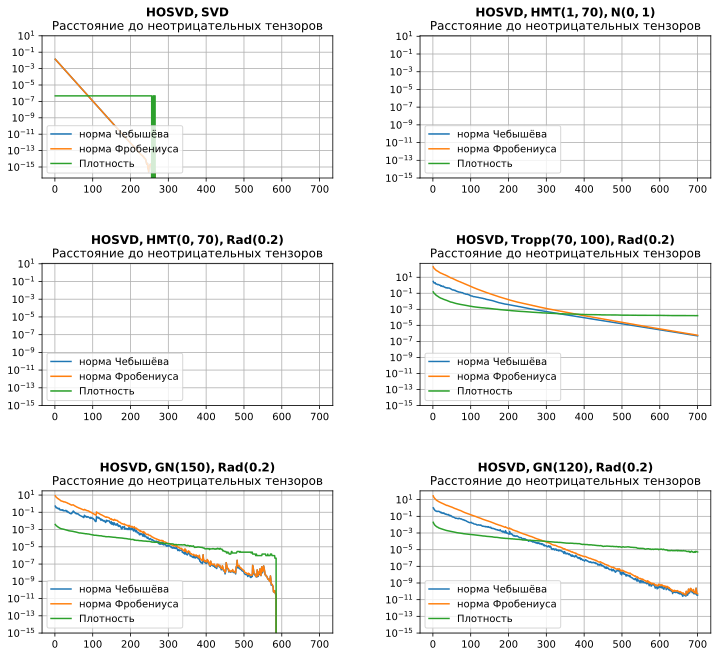

In [786]:
algs = [SVD, HMT, HMT, Tropp, GN, GN]

title = 'Расстояние до неотрицательных тензоров'
# alg_name = get_alg_name(HMT,'rademacher',0.2,0,80)
s = iters_num
fig, ax = plt.subplots(3, 2, figsize=(12, 11))

for i in range(3):
    for j in range(2):
        info = info_list[i*2 + j]
        norms = info.get_info()
        
        ax[i,j].plot(range(1, s+1), norms['chebyshev'], colors[0], label=labels[0])
        ax[i,j].plot(range(1, s+1), norms['fro'],       colors[1], label=labels[1])
        ax[i,j].plot(range(1, s+1), norms['density'],   colors[2], label=labels[2])

        ax[i,j].set_title('$\\bf{HOSVD, %s}$\n%s' % (info.get_name(), title))
        ax[i,j].grid()
        ax[i,j].set_yscale('log')
        ax[i,j].set_yticks(yticks)
        ax[i,j].legend(loc='lower left')

plt.subplots_adjust(wspace=0.3, hspace=0.6)

plt.show()